# Lab 5: Feature Engineering, Model Selection, and Overfitting

This lab will:

* Show you how linear regression can be used to model data that aren't "linear" through the process of **feature engineering**
* Show how conclusions about which model is best can be very different on the training set and the test set, which motivates the need for **model selection**
* Demonstrate the concept of **overfitting**, which is when a change to a model improves its performance on its training set at the expense of its performance on a test set.

Have fun!

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

# Set some display settings.
sns.set(context='notebook')

# Defining a "plot" dataset

The concepts of feature engineering, model selection, and overfitting all apply to models with high dimensionality. But those models get hard to visualize. So instead we're going to take some made-up **1-dimensional** data, which will let us plot the model's predictions (even though those models will actually be using higher-dimensional transformations of the data).

We've done this plotting trick in past labs/hws by having a variable we called `x`. It was easy to get that `x` confused with the training and testing data, so for this lab we'll give it a special name: the "plot dataset". It will have the same *form* as our actual data (namely, a predictor called `x`), but it's totally made up just for the purposes of plotting.

We'll use 500 points on the so-called *unit interval* (0 to 1).

In [2]:
plot_dataset = pd.DataFrame({"x": np.linspace(0.0, 1.0, 500)})

# Make the data
Run this block of code to generate the datasets... but don't peek at its contents.

In [3]:
# RUN ME
if True:
                                                                                                                                                                           data = pd.DataFrame({"x": np.linspace(0., 1., 200)}); data['y'] = .5 + 1. * np.sin(3 * data['x']) + .25 * np.random.RandomState(0).standard_normal(len(data.x)); data = data.sample(frac=1., random_state=0); train = data.iloc[:50]; test = data.iloc[50:]; del data; train.to_csv('train.csv', index=False); test.to_csv('test.csv', index=False); del train; del test

# Load and visualize our data

Load up 'train.csv' (don't look at test.csv yet).

In [4]:
train = pd.read_csv('train.csv')
print(len(train), 'datapoints')
train.head()

50 datapoints


x         y
0  0.090452  0.846306
1  0.854271  1.277217
2  0.537688  1.312243
3  0.492462  1.527369
4  0.889447  0.783395

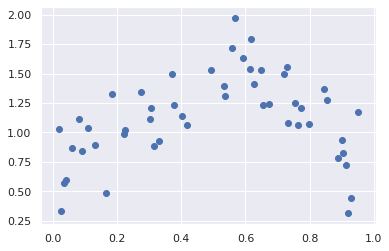

In [5]:
plt.scatter(train['x'], train['y'])

There seems to be some pattern to that data, but it might be pretty complicated. Let's try to model it!

# Linear model
First, try fitting a simple linear regression model to predict `y` from `x`.

1. **What MSE and R^2 does the linear regression model get** on the training data?
2. **Plot the training set points and the linear model on the same graph**.

In [6]:
def transform(data):
    return data[['x']]

train_X = transform(train)
train_y = train['y']

In [7]:
# Fit a linear regression
linreg = LinearRegression()
linreg.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
# Evaluate its performance. You may use the `metrics` module we imported above.
# Your code here.
y_pred = linreg.predict(train_X)
print(f"MSE: {metrics.mean_squared_error(train_y, y_pred)}, R^2: {metrics.r2_score(train_y, y_pred)}")

MSE: 0.12786877954246, R^2: 0.0405868946813569


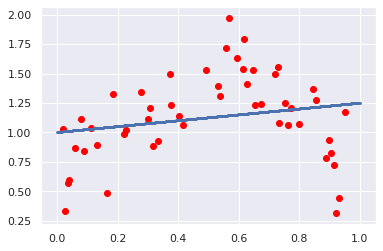

In [22]:
# Plot the training set points and the linear model
plt.scatter(train.x, train.y, color="red")

# Notice that we can use the same `transform` function on the plot dataset.
plot_X = transform(plot_dataset)

# your code here (to plot the linear model)
plt.scatter(plot_X, linreg.predict(plot_X), s=3)

# Piecewise linear approximation

Let's try modeling this data with a piecewise linear function. That is, the function doesn't have to be linear overall, but consists of gluing together linear "pieces".

There are a few ways of representing piecewise linear functions. One simple way is by representing them as a sum of "[rectifiers](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))". A *rectifier* is kind of like an absolute-value function, but instead of flipping negative values up to positive, it just chops them off (to zero) instead. These are widely used in deep neural networks these days; in this exercise you'll get a sense of how powerful these simple building blocks can be. A "rectified linear unit" (ReLU) is defined as:

$$\text{relu}(x) = \max(0, x)$$

Here's a rectifier. Try changing the `.5` to something else to see what happens.

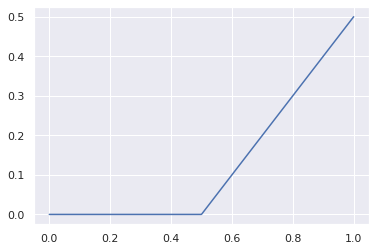

In [25]:
def relu(x):
    return np.maximum(0, x)

rectified_plot_x = relu(plot_dataset['x'] - .5)
plt.plot(plot_dataset['x'], rectified_plot_x)

It looks like data changes from going up to going down somewhere around 0.5. Let's make a rectifier with its zero point at 0.5 (like the one above) and try to use it to model our data.

The following code implements a predictive model that is *linear* in `x` and in `relu(x - .5)`. **Adjust the constants (except for 0.5) so that the model seems to roughly fit the data.**

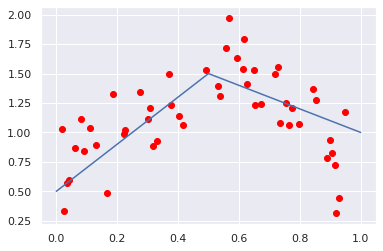

In [39]:
plt.scatter(train.x, train.y, color="red")
plt.plot(plot_dataset.x,
         0.5 + # intercept
         2.0 * plot_dataset.x + # linear term
         -3.0 * relu(plot_dataset.x - 0.5) # rectifier term
        )

Notice that the rectifier term was just another `Series`. Rather than calculate it each time, we could have put it in as a column in our dataset, like we did with one-hot encoding in class and last week's lab. Let's do that using a `transform` function like we did in class:

In [40]:
def transform(data):
    X = data[['x']].copy()
    X['rectifier_1'] = relu(data['x'] - 0.5)
    return X

Let's use that transform function to redo the plot we just did. Copy your constants from above into this cell and verify that it makes the same plot.

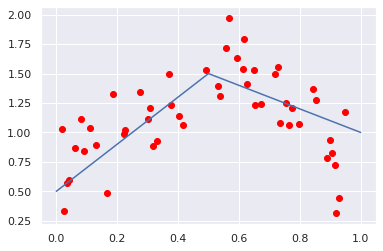

In [41]:
plot_X = transform(plot_dataset)
plt.scatter(train.x, train.y, color="red")

plt.plot(plot_dataset.x,
        0.5 + # intercept
        2.0 * plot_X['x'] + # linear term 
        -3.0 * plot_X['rectifier_1']) # rectifier term

Now that we have a `transform` function, we can use `LinearRegression` to fit those constants for us instead:

In [42]:
train_X = transform(train)
train_y = train['y']
linreg = LinearRegression().fit(train_X, train_y)

Now, check that the coefficients it came up with are about the same as the ones you came up with:

In [43]:
linreg.intercept_

0.6091000318461095

In [44]:
linreg.coef_

array([ 2.01659631, -3.75927085])

And let's plot its predictions:

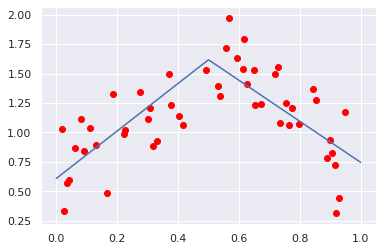

In [45]:
plt.scatter(train.x, train.y, color="red")
plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)))

What MSE and R2 does this model get on the training set?

In [47]:
metrics.mean_squared_error(train_y, linreg.predict(train_X))

0.06076589813761693

In [54]:
metrics.r2_score(train_y, linreg.predict(train_X))

0.5956495923364267

Pause to answer a few questions:

1. How does the *shape* of the second model's prediction compare with the simple linear regression model you made first?
2. The prediction isn't a straight line. In what sense is the model's prediction still *linear*?
3. In what ways does the second model seem like a good fit for the data? How could it be better?
4. How do the MSE and R^2 numbers compare between the first and second models? (self-check: does that match your intuition? no response needed)

1. The second model's prediction is a v (like an absolute value) instead of a line.
2. The model still is defined in terms of an intercept and coefficients - there are no squared terms or anything like that.
3. The second model has predictions closer to the data points, but it would be better if it allowed curves to account for the different slopes close to 0.0 and 1.0.
4. The second model has a much better MSE and R^2 score.

# Improving the model
We added a predictor (in this case, a rectifier) and got a model that performed better on the training data. Let's add more predictors to try to get an even better fit!

## Step 1

Make a single cell that combines all of the steps we performed with the second model above:

1. transforms the data,
2. fits a linear regression,
3. prints out the training set R^2 and MSE, and
4. plots the training data and the model's predictions on the same plot.

**feel free to copy and paste your earlier code**

MSE: 0.06076589813761693, R^2: 0.5440669783641089


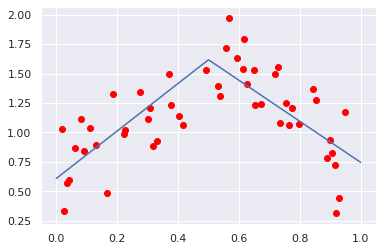

In [50]:
def transform(data):
    X = data[['x']].copy()
    X['rectifier_1'] = relu(data['x'] - 0.5)
    return X
train_X = transform(train)
train_y = train['y']
linreg = LinearRegression().fit(train_X, train_y)
y_pred = linreg.predict(train_X)
print(f"MSE: {metrics.mean_squared_error(train_y, y_pred)}, R^2: {metrics.r2_score(train_y, y_pred)}")
plt.scatter(train.x, train.y, color="red")
plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)))

## Step 2
Modify the `transform` function to add predictors to this model to try to improve its accuracy. *copy and paste your cell above* and modify it here.

Things you might try adding:

* more rectifiers
* polynomial terms ($x^2$, $x^3$ etc.)
* Periodic functions (`np.sin(2*np.pi * x)`, `np.sin(2*np.pi * 5 * x)`, `np.cos(2*np.pi * x)`, etc.)
* $\log(x+.1)$, $\exp$, ...

**See if you can get the R^2 to be above 0.75.** Feel free to write loops, etc.

*Note*: If you get tired of naming your new predictors, you can use this alternative version of `transform`.

```
def transform(data):
    x = data['x'].values
    predictors = [
        x,
        relu(x - .5), or whatever else here
    ]
    return np.stack(predictors, axis=1)
```

MSE: 0.03255197457302808, R^2: 0.7557590592393829,coefficients: [-2.40907339e+03 -2.60314787e+01  5.37096984e-01  1.29500584e-01
  1.89046786e+02  1.61279452e+03 -7.81620315e+02 -3.11668399e+02
  3.29214592e+01 -3.74937982e+01  1.09580567e+00 -5.12557593e+01
 -6.85716305e+00 -3.94307398e+01  1.20019353e+01 -6.63648262e-01
 -5.39684224e+00  2.76918966e+01]


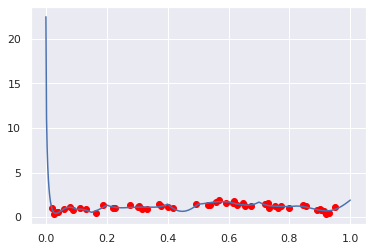

In [109]:
def transform(data):
    x = data['x'].values
    predictors = [
        x,
        relu(x - .5),
        np.sin(2*np.pi * 4 * x),
        np.cos(2*np.pi * 3.5 * x),
        np.log(x+.1),
        np.exp(x+.1),
        np.power(x, 3),
        np.sqrt(x),
        relu(x - .1),
        relu(x - .2),
        relu(x - .3),
        relu(x - .4),
        relu(x - .6),
        relu(x - .7),
        relu(x - .8),
        relu(x - .9),
        relu(x - .65),
        relu(x - .15)
    ]
    return np.stack(predictors, axis=1)
train_X = transform(train)
train_y = train['y']
linreg = LinearRegression().fit(train_X, train_y)
y_pred = linreg.predict(train_X)
print(f"MSE: {metrics.mean_squared_error(train_y, y_pred)}, R^2: {metrics.r2_score(train_y, y_pred)}," +
      f"coefficients: {linreg.coef_}")
plt.scatter(train.x, train.y, color="red")
plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)))

# Generalization
Ok, we got a model that worked great! Now let's test it on some data it hasn't seen before. Load the test data!

In [108]:
test = pd.read_csv('test.csv')

Now let's make that plot and R^2 like above, but with the test data instead of the training data.

**Important**: *don't* re-fit the model here! Just use the `linreg` model from above.

MSE: 3.5471470720853873, R^2: -22.508830072659144


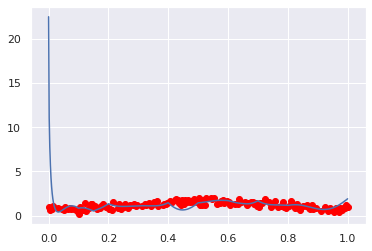

In [113]:
test_X = transform(test)
test_pred = linreg.predict(test_X)
print(f"MSE: {metrics.mean_squared_error(test.y, test_pred)}, R^2: {metrics.r2_score(test.y, test_pred)}")
plt.scatter(test.x, test.y, color="red")
plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)))

1. What do you notice? 
2. Why do you think that happened?

The model did way worse because of overfitting - it was too tuned into the very specific details of the training data and thus lost the power to generalize to the test data.

Below here, copy and paste the `transform` function, but change it to the one you would now use.

training MSE: 0.053929161608593776, R^2: 0.595363742492349
test MSE: 0.06854927478729353, R^2: 0.5456875004534042


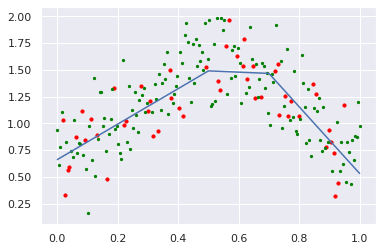

In [163]:
def transform(data):
    x = data['x'].values
    predictors = [
        x,
        relu(x - .5),
        relu(x - .7),
    ]
    return np.stack(predictors, axis=1)
train_X = transform(train)
train_y = train['y']
linreg = LinearRegression().fit(train_X, train_y)
y_pred = linreg.predict(train_X)
print(f"training MSE: {metrics.mean_squared_error(train_y, y_pred)}, R^2: {metrics.r2_score(train_y, y_pred)}")
plt.scatter(train.x, train.y, color="red", s=10)

test_X = transform(test)
test_pred = linreg.predict(test_X)
print(f"test MSE: {metrics.mean_squared_error(test.y, test_pred)}, R^2: {metrics.r2_score(test.y, test_pred)}")
plt.scatter(test.x, test.y, color="green", s=5)

plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)))

Why did you include those predictors?

My strategy was slowly removing predictors and seeing which affected the R^2 score the most. Many predictors barely affected the R^2 score, but sqrt(x), relu(x - .7), relu(x - .4), relu(x - .5), np.power(x, 3), np.exp(x + .1), np.log(x + .1), and the periodic functions all affected the R^2 on training data significantly. Then I started looking at plots to see how removing predictors got rid of weird plot patterns that didn't match data overall. The periodic functions made the plots look weird so I got rid of them. A similar deal with the square root term. Then log and exponent didn't really affect the training R^2 score any more so I removed them. I removed the x^3 term because the data didn't look cubic. Then I removed the relu(x - .4) and relu(x - .2) terms because those looked like a peculiarity of the training data and not a general trend.

So I kept only x, relu(x -.5), and relu(x - .7) because looking at the plots, those seemed to best match the patterns in the data. Also, the training R^2 score and test R^2 score were acceptable (0.59 and 0.54, respectively).

What are some things we could have *done* or *observed* that would have helped us realize that we were going to do so badly on unseen data *before* looking at the test set? How would these things have helped?

We could have looked at the coefficients of the linear model (as I printed above when I was doing the overfitting step) and seen that we were getting coefficients close to 0. That would have helped us realize that we were including things that may not be significant and as such may be too specific to the training data.